# Import packages

In [1]:
import pandas as pd
import numpy as np
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.max_columns', None)  # Prevents supression of long columns
pd.set_option('display.float_format', lambda x: '%.3f' % x)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from nltk.tokenize import RegexpTokenizer
from nltk import WordNetLemmatizer
from nltk.stem import PorterStemmer
from textblob import TextBlob
from wordcloud import WordCloud,STOPWORDS
import re
import sklearn
import seaborn as sns
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
import unidecode
import textstat
import matplotlib.pyplot as plt
import string  
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction import stop_words
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, f1_score, accuracy_score


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
C:\Users\User\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


# Load Dataset

In [2]:
df = pd.read_csv("C:\\Users\\User\\Documents\\My Documents\\MMA 865 Big Data and Text Analytics\\Individual Assignment\\sentiment_train.csv")
df.head()
df.info()
print("Total number of rows and columns : ",df.shape)

,Sentence,Polarity
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400 entries, 0 to 2399
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  2400 non-null   object
 1   Polarity  2400 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 37.6+ KB
Total number of rows and columns :  (2400, 2)


Positive words


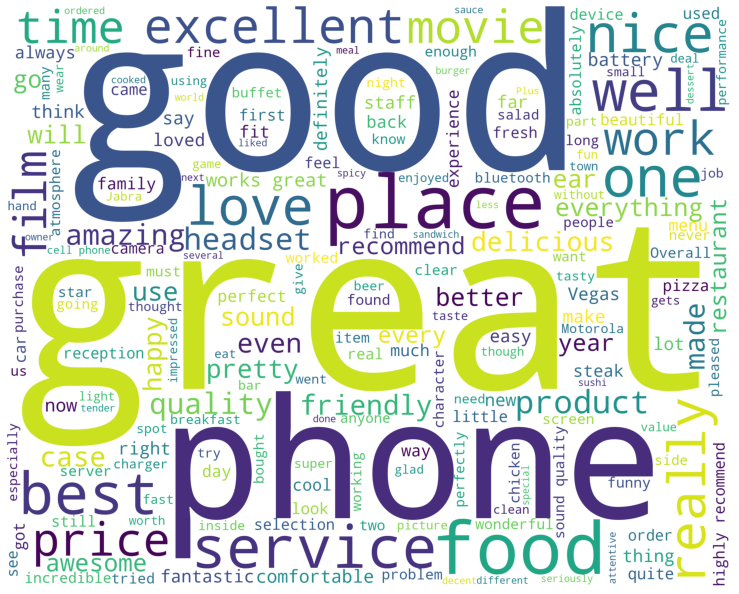

Negative words


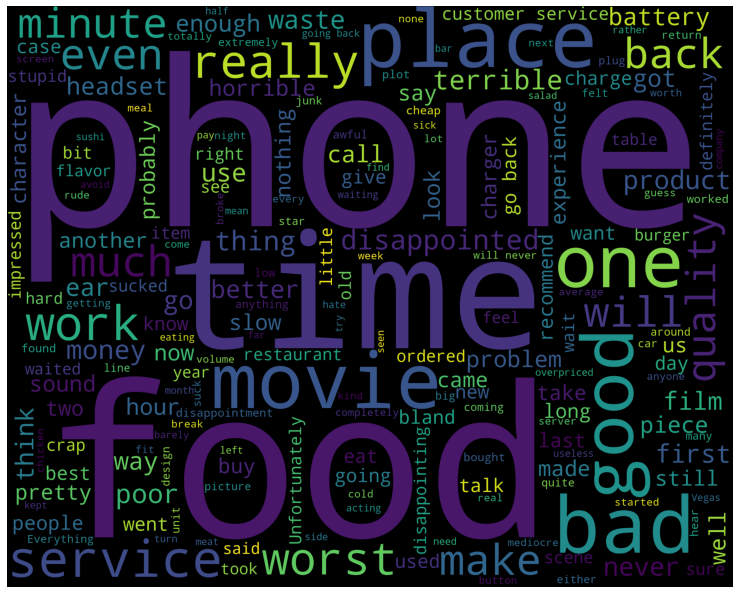

In [3]:
train_pos = df[ df['Polarity'] == 1]
train_pos = train_pos['Sentence']
train_neg = df[ df['Polarity'] == 0]
train_neg = train_neg['Sentence']
 

def wordcloud_draw(data, color = 'black'):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and not word.startswith('#')
                                and word != 'RT'
                            ])
    wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color=color,
                      width=2500,
                      height=2000
                     ).generate(cleaned_word)
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()
    
print("Positive words")
wordcloud_draw(train_pos,'white')
print("Negative words")
wordcloud_draw(train_neg)

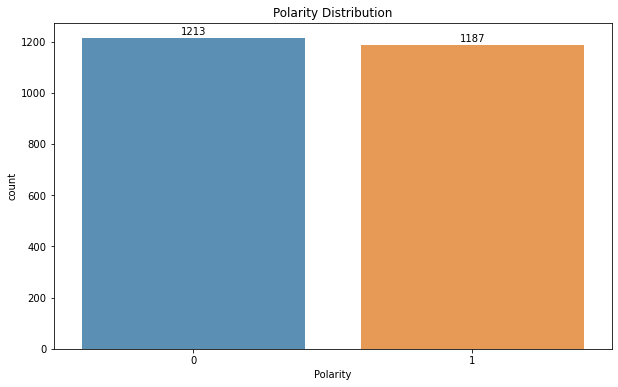

In [4]:
x=df['Polarity'].value_counts()
x=x.sort_index()
plt.figure(figsize=(10,6))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Polarity Distribution")
plt.ylabel('count')
plt.xlabel('Polarity')
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
plt.show();

In [5]:
np.bincount(df['Polarity'])

array([1213, 1187], dtype=int64)

In [33]:
X = df['Sentence']
y = df['Polarity']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

In [34]:
lemmer = WordNetLemmatizer()
def my_preprocess(x):
    
    x = re.sub(r'([xX;:]-?[dD)]|:-?[\)]|[;:][pP])', 'good',x)
    
    x = re.sub(r"(:'?[/|\(]) ", 'bad',x)
    
    x = re.sub('-',' ',x)
    
    x = x.lower()
    
    x = re.sub(r'[^\w\s]', '', x)
    
    x = unidecode.unidecode(x)
    
    x = [lemmer.lemmatize(w) for w in x.split()]

    return ' '.join(x)

# Custom Functions for processing and feature engineering

In [28]:
def doc_length(corpus):
    return np.array([len(doc) for doc in corpus]).reshape(-1, 1)

def lexicon_count(corpus):
    return np.array([textstat.lexicon_count(doc) for doc in corpus]).reshape(-1, 1)

def sentence_count(corpus):
    return np.array([textstat.sentence_count(doc) for doc in corpus]).reshape(-1, 1)

def readability_index(corpus):
    return np.array([textstat.automated_readability_index(doc) for doc in corpus]).reshape(-1, 1)

def _get_punc(doc):
    return len([a for a in doc if a in string.punctuation])

def punc_count(corpus):
    return np.array([_get_punc(doc) for doc in corpus]).reshape(-1, 1)

def num_exclamation_marks(corpus):
    return np.array([doc.count('!') for doc in corpus]).reshape(-1, 1)

def has_exclamation(corpus):
    return np.array([bool(re.search("!", doc.lower())) for doc in corpus]).reshape(-1, 1)

def num_question_marks(corpus):
    return np.array([doc.count('?') for doc in corpus]).reshape(-1, 1)

def get_compound_score(corpus):
    return np.array([sid.polarity_scores(doc)['compound'] for doc in corpus]).reshape(-1, 1)

def get_sentiment_polarity(corpus):
    return np.array([TextBlob(doc).sentiment.polarity for doc in corpus]).reshape(-1, 1)

def get_sentiment_subjectivity(corpus):
    return np.array([TextBlob(doc).sentiment.subjectivity for doc in corpus]).reshape(-1, 1)

In [29]:
vectorizer = TfidfVectorizer(preprocessor=my_preprocess, 
                             max_features = 1000, 
                             ngram_range=[1,4],
                             stop_words=None,
                             strip_accents="unicode", 
                             lowercase=False, max_df=0.25, min_df=0.001, use_idf=True)

lr = LogisticRegression(max_iter = 500,random_state=42,class_weight='balanced')

feature_processing =  FeatureUnion([ 
    ('bow', Pipeline([('cv', vectorizer), ])),
    ('length', FunctionTransformer(doc_length, validate=False)),
    ('words', FunctionTransformer(lexicon_count, validate=False)),
    ('sentences', FunctionTransformer(sentence_count, validate=False)),
    ('readability_index', FunctionTransformer(readability_index, validate=False)),
    ('punc_count', FunctionTransformer(punc_count, validate=False)),
    ('num_exclamation_marks', FunctionTransformer(num_exclamation_marks, validate=False)),  
    ('has_exclamation', FunctionTransformer(has_exclamation, validate=False)),
    ('num_question_marks', FunctionTransformer(num_question_marks, validate=False)),
    ('sentiment_polarity', FunctionTransformer(get_sentiment_polarity, validate=False)),
    ('sentiment_subjectivity', FunctionTransformer(get_sentiment_subjectivity, validate=False)),
    ('compound_score', FunctionTransformer(get_compound_score, validate=False)),
])


pipe = Pipeline([('features', feature_processing), ('clf', lr)])



In [30]:
pipe.fit(X_train, y_train)

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('bow',
                                                 Pipeline(steps=[('cv',
                                                                  TfidfVectorizer(lowercase=False,
                                                                                  max_df=0.25,
                                                                                  max_features=1000,
                                                                                  min_df=0.001,
                                                                                  ngram_range=[1,
                                                                                               4],
                                                                                  preprocessor=<function my_preprocess at 0x00000173BB480D38>,
                                                                                  strip_accents='unicode'))])),


In [31]:

pred_val = pipe.predict(X_val)

print("Confusion matrix:")
print(confusion_matrix(y_val, pred_val))

print("\nF1 Score = {:.5f}".format(f1_score(y_val, pred_val, average='micro')))

print("\nClassification Report:")
print(classification_report(y_val, pred_val))

Confusion matrix:
[[114  15]
 [ 10 101]]

F1 Score = 0.89583

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.88      0.90       129
           1       0.87      0.91      0.89       111

    accuracy                           0.90       240
   macro avg       0.90      0.90      0.90       240
weighted avg       0.90      0.90      0.90       240



# Performance on Test Dataset

In [35]:
test_df = pd.read_csv("C:\\Users\\User\\Documents\\My Documents\\MMA 865 Big Data and Text Analytics\\Individual Assignment\\sentiment_test.csv")
pred_test = pipe.predict(test_df['Sentence'])

solution_df = pd.read_csv("C:\\Users\\User\\Documents\\My Documents\\MMA 865 Big Data and Text Analytics\\Individual Assignment\\sentiment_test.csv")
y_test = solution_df['Polarity']

print("Confusion matrix:")
print(confusion_matrix(y_test, pred_test))

print("\nF1 Score = {:.5f}".format(f1_score(y_test, pred_test, average="micro")))
print("\nF1 Accuracy Score = {:.5f}".format(accuracy_score(y_test, pred_test)))

print("\nClassification Report:")
print(classification_report(y_test, pred_test))

Confusion matrix:
[[254  33]
 [ 74 239]]

F1 Score = 0.82167

F1 Accuracy Score = 0.82167

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.89      0.83       287
           1       0.88      0.76      0.82       313

    accuracy                           0.82       600
   macro avg       0.83      0.82      0.82       600
weighted avg       0.83      0.82      0.82       600



In [14]:
final_predicted = pd.DataFrame({'Sentence': test_df.Sentence, 'Actual Polarity':test_df.Polarity,'Predicted Polarity': pred_test})
Result = final_predicted[final_predicted['Actual Polarity'] != final_predicted['Predicted Polarity']]
Result.style.set_properties(subset=['Sentence'], **{'width': '600px'})
Result.head(600)


,Sentence,Actual Polarity,Predicted Polarity
3,It's a feel-good film and that's how I felt when I came out of the cinema!,1,0
12,Not too screamy not to masculine but just right.,1,0
36,"The soundtrack wasn't terrible, either.",1,0
38,"Still, it was the SETS that got a big ""10"" on my ""oy-vey"" scale.",1,0
43,The last 15 minutes of movie are also not bad as well.,1,0
49,"I won't say any more - I don't like spoilers, so I don't want to be one, but I believe this film is worth your time.",1,0
53,Not even good for camp value!,0,1
57,If only someone involved with it knew how to string together narrative!,0,1
62,"Considering the relations off screen between Taylor and Stanwyck, it was surprising how little chemistry there was on screen between the two of them.",0,1
77,The directing is sloppy at best.,0,1


,Sentence,Actual Polarity,Predicted Polarity
3,It's a feel-good film and that's how I felt wh...,1,0
12,Not too screamy not to masculine but just righ...,1,0
36,"The soundtrack wasn't terrible, either.",1,0
38,"Still, it was the SETS that got a big ""10"" on ...",1,0
43,The last 15 minutes of movie are also not bad ...,1,0
...,...,...,...
566,"Each track commands sentiment, actually contri...",1,0
567,Definitely worth seeing it's the sort of thou...,1,0
572,"If you act in such a film, you should be glad ...",0,1
581,I keep watching it over and over.,1,0
